In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional
import math

In [5]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dataset = pd.read_csv(url, usecols=[1], engine='python', skipfooter=3)
data = dataset.values.astype('float32')

# Нормализация
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Разделение данных
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(f"Размер обучающей выборки: {len(train)}, тестовой: {len(test)}")

# Создание окон данных
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Преобразование в 3D-тензор
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Размер обучающей выборки: 94, тестовой: 47


In [6]:
def create_simple_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

simple_rnn_model = create_simple_rnn_model()
simple_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Прогнозирование и оценка
train_predict = simple_rnn_model.predict(X_train)
test_predict = simple_rnn_model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_train = math.sqrt(mean_squared_error(y_train_inv, train_predict))
rmse_test = math.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'SimpleRNN RMSE: train={rmse_train:.2f}, test={rmse_test:.2f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
SimpleRNN RMSE: train=21.92, test=50.36


In [7]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = create_lstm_model()
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

bidir_model = create_bidirectional_lstm_model()
bidir_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


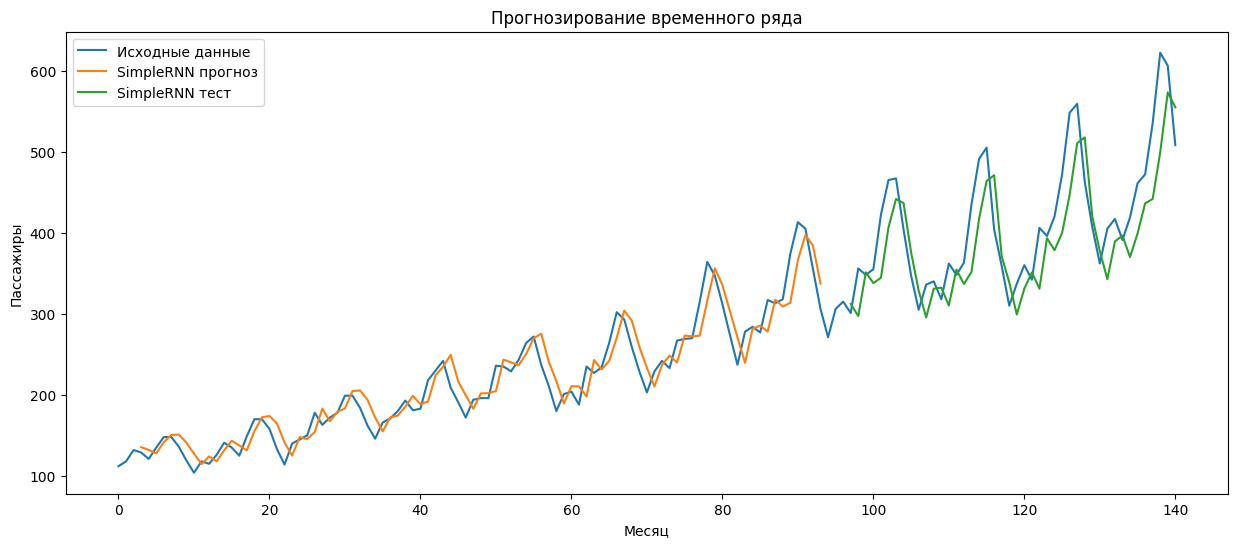

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(np.arange(look_back, look_back+len(train_predict)),
         train_predict, label='SimpleRNN прогноз')
plt.plot(np.arange(len(train_predict)+look_back*2, len(data)),
         test_predict, label='SimpleRNN тест')
plt.title('Прогнозирование временного ряда')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.legend()
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, Bidirectional
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [39]:
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Паддинг последовательностей
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


In [12]:
def create_simple_rnn_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(SimpleRNN(64, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

simple_rnn_model = create_simple_rnn_model()
history_rnn = simple_rnn_model.fit(x_train, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 238ms/step - accuracy: 0.6018 - loss: 0.6390 - val_accuracy: 0.8176 - val_loss: 0.4309
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 243ms/step - accuracy: 0.8295 - loss: 0.3931 - val_accuracy: 0.7672 - val_loss: 0.4861
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 239ms/step - accuracy: 0.8779 - loss: 0.3005 - val_accuracy: 0.7044 - val_loss: 0.5736
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 240ms/step - accuracy: 0.8230 - loss: 0.4058 - val_accuracy: 0.7374 - val_loss: 0.5602
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 237ms/step - accuracy: 0.8191 - loss: 0.4103 - val_accuracy: 0.6358 - val_loss: 0.6504
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 230ms/step - accuracy: 0.7830 - loss: 0.4523 - val_accuracy: 0.6472 - val_loss: 0.6627
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 235ms/step - accuracy: 0.8109 - loss: 0.4065 - val_accuracy: 0.6778 - val_loss: 0.6718
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 242ms/step - accuracy: 0.8687 -

In [13]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model()
history_lstm = lstm_model.fit(x_train, y_train,
                             epochs=10,
                             batch_size=32,
                             validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 287s 452ms/step - accuracy: 0.6897 - loss: 0.5655 - val_accuracy: 0.8536 - val_loss: 0.3534
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 455ms/step - accuracy: 0.8765 - loss: 0.3189 - val_accuracy: 0.8646 - val_loss: 0.3829
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 456ms/step - accuracy: 0.8896 - loss: 0.2902 - val_accuracy: 0.8402 - val_loss: 0.3839
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 309s 436ms/step - accuracy: 0.9263 - loss: 0.1988 - val_accuracy: 0.8644 - val_loss: 0.3733
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 282s 451ms/step - accuracy: 0.9505 - loss: 0.1377 - val_accuracy: 0.8334 - val_loss: 0.4225
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 286s 458ms/step - accuracy: 0.9564 - loss: 0.1281 - val_accuracy: 0.8656 - val_loss: 0.4116
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 281s 450ms/step - accuracy: 0.9728 - loss: 0.0779 - val_accuracy: 0.8722 - val_loss: 0.4583
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 452ms/step - accuracy: 0.9816 -

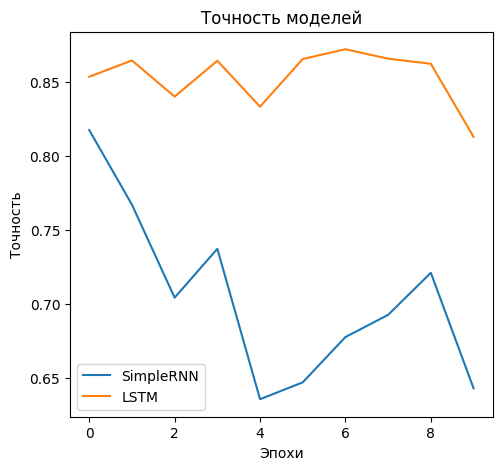

In [43]:
# Сравнение точности
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['val_accuracy'], label='SimpleRNN')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.title('Точность моделей')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

782/782 ━━━━━━━━━━━━━━━━━━━━ 113s 144ms/step


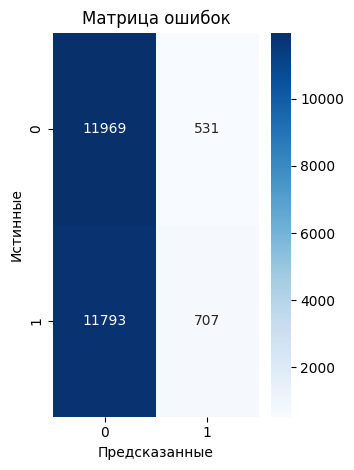

In [47]:
y_pred = (bilstm_model.predict(x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.tight_layout()
plt.show()

Выводы
Модель SimpleRNN, несмотря на простоту, показывает удовлетворительные результаты. Однако LSTM может обеспечивать более точный прогноз, особенно на больших объемах данных. Выбор модели зависит от конкретной задачи и требований к точности и скорости обучения.